# Binary classfication using HOG-RGB
- Just training a simple binary classifier using 4 fold train/test data
- Not using real test data here (as it has been centred using cell boundaries by Shila, we will not have this luxury when our modle is deployed)
- Just gauging accuracy of train/test split + stratified/down+up sampling strategy

- HOG for feature extraction, for each channel so RGB
- images are resized to 100x100 for this
- then fed to knn or rf

## Prepare env

In [13]:
import pandas as pd
import skimage as ski
import sklearn as skl
import numpy as np
import os
import sys
import matplotlib.pyplot as plt


RANDOM_SEED = 3888
# adjust this based on what strategy has been used to produce train/test folds + what image size
# code assumes image_dir/folds/classes/[images here] structure
IMAGE_DIR = os.path.join("projectdata", "images", "images_100_4fold_stratified_up_down")
# can change fold list 
FOLDS = ["Q1", "Q2", "Q3", "Q4"]
CLASSES = ["Tumor", "Non-Tumor"]
DESIRED_IMAGE_SIZE = 100

np.random.seed(RANDOM_SEED)
print(sys.version)

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]


### prepare HOG RGB of images
- load images + resize to desired size
- compute HOG RGB features
- disregard the actual image data to save memory right here

  fold  class                                           filepath  \
0   Q1  Tumor  projectdata\images\images_100_4fold_stratified...   

                                             hog_rgb  
0  [0.10606383858412972, 0.07456191442256833, 0.0...  
fold        object
class       object
filepath    object
hog_rgb     object
dtype: object
[0.10606384 0.07456191 0.09869751 ... 0.26402021 0.2586929  0.16405896]
<class 'numpy.ndarray'>
_100_4fold_stratified_up_down\Q1\Tumor\cell_1700_100.png


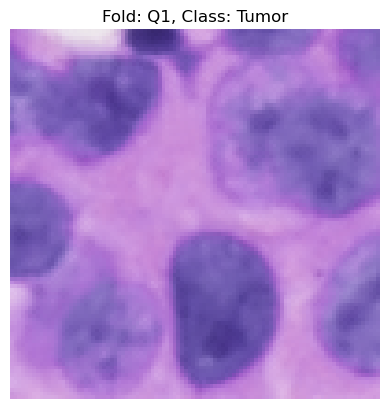

In [ ]:
# compute all hog_rgbs
image_df = pd.DataFrame(columns=["fold", "class", "filepath", "hog_rgb"])

def compute_hog_rgb_feats(image, cells = 6, orientations = 9):
    """ 
    Compute HOG for each color channel, making hog rgb.
    by default, using 9 orientations - og paper suggests this, splitting image into 6x6 cells (so DESIRED_IMAGE_SIZE/6 pixels per cell) - arbritary, chosen from online resources, 
    and using 2x2 cells per block - og paper suggests this?
    block_norm left as package default block_norm='L2-Hys'.
    """
    hog_features = []
    for channel in range(3):  # Assuming RGB image
        channel_hog = ski.feature.hog(image[:, :, channel], 
                            pixels_per_cell=(DESIRED_IMAGE_SIZE // cells, DESIRED_IMAGE_SIZE // cells), cells_per_block=(2, 2), orientations = orientations, 
                            visualize=False)
        hog_features.append(channel_hog)
    return np.concatenate(hog_features)

first = True
for fold in FOLDS:
    for label in CLASSES:
        folder_path = os.path.join(IMAGE_DIR, fold, label)

        if not os.path.isdir(folder_path):
            raise ValueError(f"folder path {folder_path} is not found! something is setup wrong!")
        for image_fname in os.listdir(folder_path):
            image_fpath = os.path.join(folder_path, image_fname)
            if not os.path.isfile(image_fpath):
                raise ValueError(f"image path {image_fpath} is not found! something is setup wrong!")

            # read image
            image = ski.io.imread(image_fpath)

            # crop image to the desired size
            start_x = (image.shape[1] - DESIRED_IMAGE_SIZE) // 2 # columns, x coordinate
            start_y = (image.shape[0] - DESIRED_IMAGE_SIZE) // 2 # rows, y coordinate
            image = image[start_y:start_y + DESIRED_IMAGE_SIZE, start_x:start_x + DESIRED_IMAGE_SIZE]
            hog_rgb = compute_hog_rgb_feats(image)
            image_df = pd.concat([image_df, pd.DataFrame([[fold, label, image_fpath, hog_rgb]], 
                                                            columns=["fold", "class", "filepath", "hog_rgb"])], 
                                    ignore_index=True)
            
            # print some general info for first pass
            if first:
                first = False
                print(image_df.head())
                print(image_df.dtypes)
                print(image_df["hog_rgb"][0])
                print(type(image_df["hog_rgb"][0]))
                print(image_df["filepath"][0][25:])
                plt.imshow(image)
                plt.title(f"Fold: {fold}, Class: {label}")
                plt.axis('off')
                plt.show()

## Use HOG-RGB in 4-fold CV for binary classification
- classify tumour from non tumour
- holdout one quadrant, use rest in training of knn or random forest
- evaluate accuracy and f1 for each fold, visualise this

### rf
- using default hyperparms, notably max_features = sqrt(total features)

Fold: Q1
              precision    recall  f1-score   support

   Non-Tumor       0.66      0.79      0.72       527
       Tumor       0.61      0.45      0.52       388

    accuracy                           0.64       915
   macro avg       0.64      0.62      0.62       915
weighted avg       0.64      0.64      0.63       915

Fold: Q2
              precision    recall  f1-score   support

   Non-Tumor       0.69      0.79      0.73       527
       Tumor       0.63      0.51      0.56       383

    accuracy                           0.67       910
   macro avg       0.66      0.65      0.65       910
weighted avg       0.66      0.67      0.66       910

Fold: Q3
              precision    recall  f1-score   support

   Non-Tumor       0.65      0.70      0.68       527
       Tumor       0.60      0.55      0.58       436

    accuracy                           0.63       963
   macro avg       0.63      0.63      0.63       963
weighted avg       0.63      0.63      0.63    

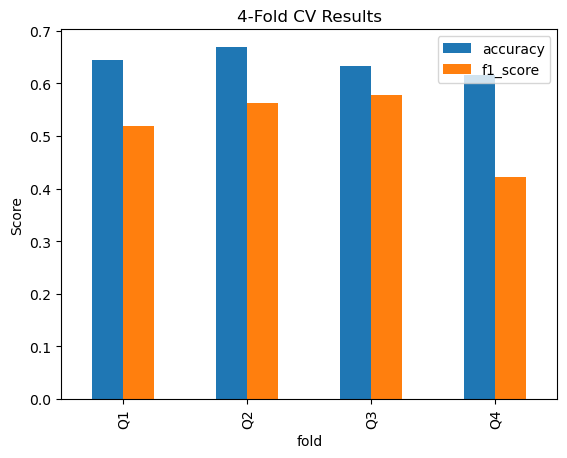

In [ ]:

# Prepare results storage
results = []

# Iterate through each fold
for test_fold in FOLDS:
    # Split data into training and testing based on the fold
    train_data = image_df[image_df['fold'] != test_fold]
    test_data = image_df[image_df['fold'] == test_fold]
    
    # Extract features and labels
    X_train = np.stack(train_data['hog_rgb'].values)
    y_train = train_data['class'].values
    X_test = np.stack(test_data['hog_rgb'].values)
    y_test = test_data['class'].values
    
    # Initialize classifier (change to KNeighborsClassifier if needed)
    rf = skl.ensemble.RandomForestClassifier(random_state=RANDOM_SEED)
    
    # Train the classifier
    rf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf.predict(X_test)
    
    # Evaluate performance
    acc = skl.metrics.accuracy_score(y_test, y_pred)
    f1 = skl.metrics.f1_score(y_test, y_pred, pos_label='Tumor')
    results.append({'fold': test_fold, 'accuracy': acc, 'f1_score': f1})
    
    # Print classification report for the fold
    print(f"Fold: {test_fold}")
    print(skl.metrics.classification_report(y_test, y_pred))

# Visualize results
results_df = pd.DataFrame(results)
results_df.plot(x='fold', y=['accuracy', 'f1_score'], kind='bar', title='4-Fold CV Results for rf on HOG-RGB')
plt.ylabel('Score')
plt.show()

### knn
- using grid search to pick k, between 1 and 20 neighbours, nested 3 fold cv, by accuracy (note, balanced classes)

c:\Users\Yash Agarwal\.conda\envs\tf_py3_10\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Yash Agarwal\.conda\envs\tf_py3_10\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Fold: Q1, k:12
              precision    recall  f1-score   support

   Non-Tumor       0.81      0.39      0.53       527
       Tumor       0.51      0.87      0.65       388

    accuracy                           0.60       915
   macro avg       0.66      0.63      0.59       915
weighted avg       0.68      0.60      0.58       915

Fold: Q2, k:16
              precision    recall  f1-score   support

   Non-Tumor       0.78      0.43      0.55       527
       Tumor       0.51      0.83      0.64       383

    accuracy                           0.60       910
   macro avg       0.65      0.63      0.59       910
weighted avg       0.67      0.60      0.59       910

Fold: Q3, k:10
              precision    recall  f1-score   support

   Non-Tumor       0.75      0.51      0.61       527
       Tumor       0.57      0.79      0.66       436

    accuracy                           0.64       963
   macro avg       0.66      0.65      0.64       963
weighted avg       0.67      

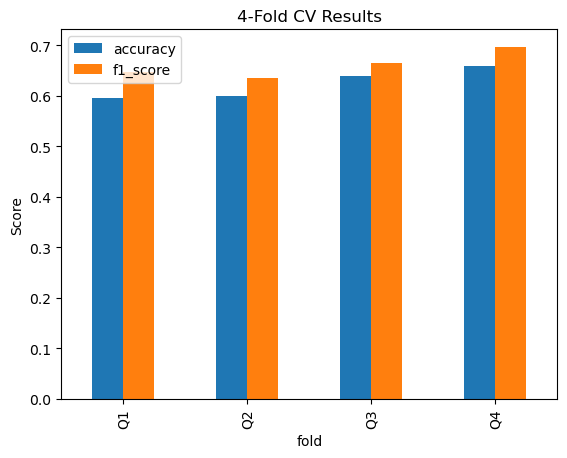

In [ ]:
# Prepare results storage + hyperparam grid
results = []
param_grid = {'n_neighbors': range(1, 20)}

# Iterate through each fold
for test_fold in FOLDS:
    # Split data into training and testing based on the fold
    train_data = image_df[image_df['fold'] != test_fold]
    test_data = image_df[image_df['fold'] == test_fold]
    
    # Extract features and labels
    X_train = np.stack(train_data['hog_rgb'].values)
    y_train = train_data['class'].values
    X_test = np.stack(test_data['hog_rgb'].values)
    y_test = test_data['class'].values
    
    # Perform grid search for optimal k
    
    grid_search = skl.model_selection.GridSearchCV(skl.neighbors.KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Use the best estimator from grid search
    knn = grid_search.best_estimator_

    # Train the classifier
    knn.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Evaluate performance
    acc = skl.metrics.accuracy_score(y_test, y_pred)
    f1 = skl.metrics.f1_score(y_test, y_pred, pos_label='Tumor')
    results.append({'fold': test_fold, 'accuracy': acc, 'f1_score': f1})
    
    # Print classification report for the fold
    best_k = grid_search.best_params_["n_neighbors"]
    print(f"Fold: {test_fold}, k:{best_k}")
    print(skl.metrics.classification_report(y_test, y_pred))

# Visualize results
results_df = pd.DataFrame(results)
results_df.plot(x='fold', y=['accuracy', 'f1_score'], kind='bar', title='4-Fold CV Results for k-NN on HOG-RGB')
plt.ylabel('Score')
plt.show()